In [4]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [5]:
# !curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0  333k    0     0   301k      0  0:44:28  0:00:01  0:44:27  301k
  0  786M    0 2993k    0     0  1337k      0  0:10:02  0:00:02  0:10:00 1337k
  0  786M    0 6819k    0     0  2034k      0  0:06:35  0:00:03  0:06:32 2034k
  1  786M    1 14.8M    0     0  3617k      0  0:03:42  0:00:04  0:03:38 3618k
  2  786M    2 19.6M    0     0  3806k      0  0:03:31  0:00:05  0:03:26 3859k
  3  786M    3 26.7M    0     0  4481k      0  0:02:59  0:00:06  0:02:53 5404k
  4  786M    4 33.5M    0     0  4843k      0  0:02:46  0:00:07  0:02:39 6460k
  4  786M    4 38.2M    0     0  4862k      0  0:02:45  0:00:08  0:02:37 6874k
  5  786M    5 44.6M    0     0  5003k      0  0:02

In [5]:
# !unzip -q kagglecatsanddogs_5340.zip
!ls
!ls PetImages

[kagglecatsanddogs_5340.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of kagglecatsanddogs_5340.zip or
        kagglecatsanddogs_5340.zip.zip, and cannot find kagglecatsanddogs_5340.zip.ZIP, period.
 CDLA-Permissive-2.0.pdf      mtcnnFaceCrop.py	'readme[1].txt'
 kagglecatsanddogs_5340.zip   PetImages		 test.ipynb
Cat  Dog


In [6]:
badFileCount = 0

for folderName in ("Cat","Dog"):
    folderPath = os.path.join("PetImages", folderName)
    for fName in os.listdir(folderPath):
        fPath = os.path.join(folderPath, fName)
        try:
            fObj = open(fPath,'rb')
            is_jfif = b"JFIF" in fObj.peek(10)
        finally:
            fObj.close()        
        
        if not is_jfif:
            badFileCount += 1
            os.remove(fPath)

print(f"Deleted Files : {badFileCount}");

"""
    The purpose of this check is to determine if the file is a valid JPEG image. 
    The "JFIF" string is a common marker found in the header of JPEG files, indicating that the file is in the JPEG File Interchange Format (JFIF). 
    If this string is not found in the first 10 bytes, the file is likely not a valid JPEG image, and the code will increment the badFileCount variable and remove the file.
"""

Deleted Files : 1578


'\n    The purpose of this check is to determine if the file is a valid JPEG image. \n    The "JFIF" string is a common marker found in the header of JPEG files, indicating that the file is in the JPEG File Interchange Format (JFIF). \n    If this string is not found in the first 10 bytes, the file is likely not a valid JPEG image, and the code will increment the badFileCount variable and remove the file.\n'

In [7]:
# delete corrupt files
"""
    rewrite corrupt images with 
    mogrify *.jpg command in the images containing directory
"""

'\n    rewrite corrupt images with \n    mogrify *.jpg command in the images containing directory\n'

In [24]:
imageSize = (180,180)
batchSize = 32

trainDs = keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    seed = 1234,
    validation_split=0.2,
    shuffle = True,
    subset="training",
    image_size = imageSize,
    batch_size = batchSize
)

valDs = keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    seed=1234,
    image_size=imageSize,
    batch_size=batchSize
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


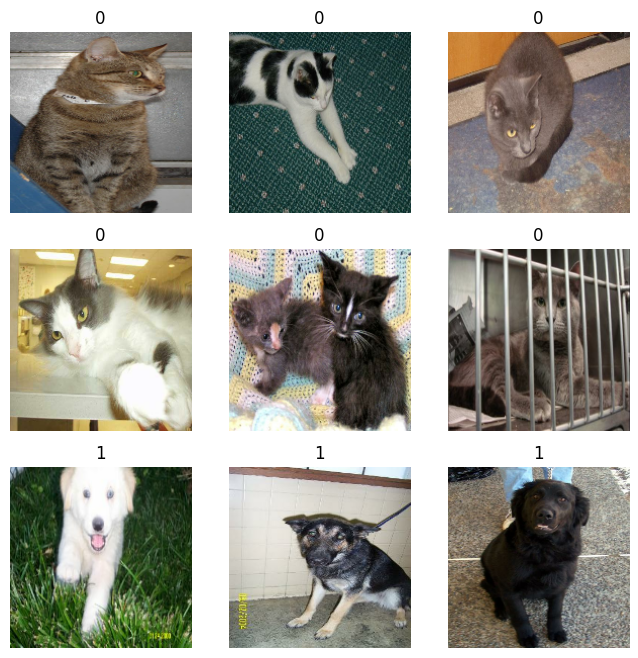

In [11]:
plt.figure(figsize=(8,8))
for images, labels in trainDs.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [12]:
dataAugmentationLayers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in dataAugmentationLayers:
        images = layer(images)
    return images

In [13]:
from mtcnn.mtcnn import MTCNN

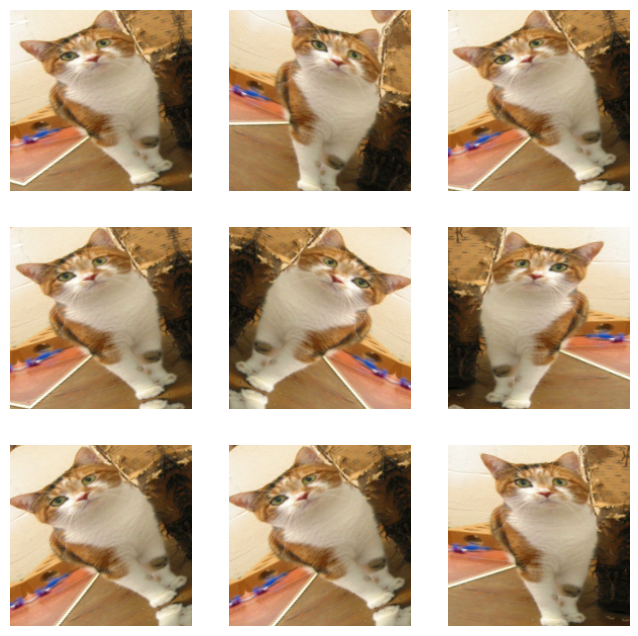

In [14]:
plt.figure(figsize=(8,8))
for images, _ in trainDs.take(1):
    for i in range(9):
        augImages = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(np.array(augImages[0]).astype("uint8"))
        plt.axis("off")

In [25]:
trainDs = trainDs.prefetch(tf_data.AUTOTUNE)
valDs = valDs.prefetch(tf_data.AUTOTUNE)

In [26]:
def make_model(inputShape, numClassses):
    inputs = keras.Input(shape=inputShape)

    #data augmentation
    x = data_augmentation(inputs)
    #entry block
    x = layers.Rescaling(1.0/255)(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previousBlockActivation = x

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        #project residual
        residual = layers.Conv2D(size, 1 , strides=2, padding="same")(previousBlockActivation)
        x = layers.add([x, residual])

        previousBlockActivation = x
    
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if numClassses == 2:
        units = 1
    else:
        units = numClassses
    
    x = layers.Dropout(0.25)(x)

    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

In [27]:
catNdogModel = make_model(inputShape=imageSize + (3,), numClassses=2)
catNdogModel.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip (RandomFlip)       (None, 180, 180, 3)  0           ['input_3[0][0]']                
                                                                                                  
 random_rotation (RandomRotatio  (None, 180, 180, 3)  0          ['random_flip[2][0]']            
 n)                                                                                               
                                                                                            

In [28]:
#model training
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras")
]

catNdogModel.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
)

catNdogModel.fit(
    trainDs,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=valDs,
)

Epoch 1/25
586/586 [==============================] - 230s 387ms/step - loss: 0.5738 - accuracy: 0.6878 - val_loss: 1.1061 - val_accuracy: 0.5032
Epoch 2/25
586/586 [==============================] - 265s 451ms/step - loss: 0.4176 - accuracy: 0.7986 - val_loss: 0.4232 - val_accuracy: 0.8356
Epoch 3/25
586/586 [==============================] - 293s 500ms/step - loss: 0.3285 - accuracy: 0.8498 - val_loss: 0.5512 - val_accuracy: 0.7222
Epoch 4/25
586/586 [==============================] - 289s 493ms/step - loss: 0.2783 - accuracy: 0.8753 - val_loss: 0.6113 - val_accuracy: 0.7351
Epoch 5/25
586/586 [==============================] - 264s 451ms/step - loss: 0.2329 - accuracy: 0.8989 - val_loss: 0.2548 - val_accuracy: 0.8896
Epoch 6/25
586/586 [==============================] - 267s 455ms/step - loss: 0.2109 - accuracy: 0.9088 - val_loss: 0.3401 - val_accuracy: 0.8911
Epoch 7/25
586/586 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9179

KeyboardInterrupt: 

In [29]:
catNdogModel = keras.models.load_model('./save_at_6.keras')

In [33]:
from PIL import Image

1/1 [==============================] - 0s 18ms/step
This image is 9.36% cat and 90.64% dog.


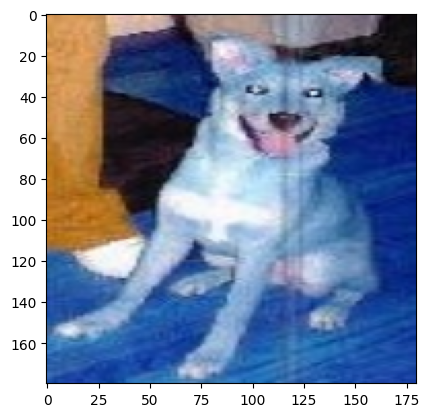

In [39]:
img = cv2.imread('PetImages/Dog/12.jpg')
img = cv2.resize(img, (180,180))
plt.imshow(img)

imgArray = keras.utils.img_to_array(img)
imgArray = tf.expand_dims(imgArray, 0)

preds = catNdogModel.predict(imgArray)
score = float(keras.activations.sigmoid(preds[0][0]))

print(f"This image is {100 * (1-score):.2f}% cat and {100 * score:.2f}% dog.")